## Config

In [230]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from punisher.common import *

import itertools
import sklearn
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn import preprocessing
import statsmodels.formula.api as smf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helpers

In [231]:
def plot_AB(y1, y2, x=None, fs=(20,12), title=None):
    if x is None:
        x = np.array([i for i in range(len(y1))])
    fig, ax = plt.subplots()
    fig.set_size_inches(fs)
    plt.title(title)
    plt.plot(x, y1, label='preds')
    plt.plot(x, y2, label='targs')
    plt.grid()
    legend = ax.legend(loc='upper left')
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Data Feed

In [232]:
# https://coinmarketcap.com/api/
exchange_id = ex_cfg.POLONIEX
asset = Asset(coins.ETH, coins.BTC)
start = datetime.datetime(year=2016, month=1, day=1)
end = datetime.datetime(year=2018, month=1, day=1)
timeframe = Timeframe.THIRTY_MIN
exchange = load_exchange(exchange_id)
#ohlcv_feed.fetch_and_save_asset(exchange, asset, timeframe, start, end)
#feed = OHLCVFileFeed([exchange_id], [asset], timeframe, start, end)
fpath = ohlcv_feed.get_ohlcv_fpath(asset, exchange_id, timeframe)
df = ohlcv_feed.load_asset(fpath)
df.sort_values(by='utc', inplace=True)
close_col = ohlcv_feed.get_col_name('close', asset.symbol, exchange_id)
volume_col = ohlcv_feed.get_col_name('volume', asset.symbol, exchange_id)
df['lead'] = df[close_col].rolling(250).mean()
df['lag'] = df[close_col].rolling(1000).mean()
df.dropna(inplace=True)
df.head()

,open_ETH/BTC_poloniex,high_ETH/BTC_poloniex,low_ETH/BTC_poloniex,close_ETH/BTC_poloniex,volume_ETH/BTC_poloniex,utc,lead,lag
epoch,,,,,,,,
1453404600,0.003669,0.003694,0.003657,0.003670,4.463867,2016-01-21 19:30:00,0.003562,0.002671
1453406400,0.003670,0.003690,0.003637,0.003669,13.522759,2016-01-21 20:00:00,0.003563,0.002672
1453408200,0.003640,0.003670,0.003615,0.003649,69.488870,2016-01-21 20:30:00,0.003564,0.002674
1453410000,0.003649,0.003698,0.003649,0.003698,14.745662,2016-01-21 21:00:00,0.003565,0.002675
1453411800,0.003698,0.003700,0.003665,0.003682,9.928688,2016-01-21 21:30:00,0.003566,0.002677


In [233]:
train = df[df['utc'] < datetime.datetime(year=2017, month=9, day=1)]
val = df[df['utc'] >= datetime.datetime(year=2017, month=9, day=1)]

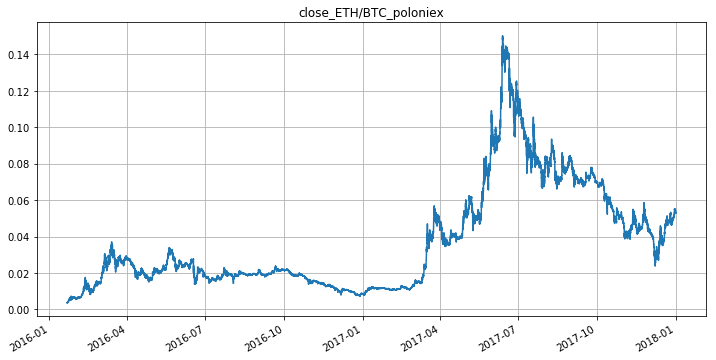

In [234]:
punisher.utils.charts.plot_range(
    df, start=None, end=None, 
    column_name='close_ETH/BTC_'+exchange_id)

## SMA

* https://medium.com/@eliquinox/cryptocurrency-data-analysis-part-iii-backtesting-evaluating-and-optimising-a-trading-strategy-9bc9b1179a8b
* https://www.investopedia.com/university/movingaverage/movingaverages4.asp
* https://blog.patricktriest.com/analyzing-cryptocurrencies-python/
* https://github.com/AdamStone/cryptrade
* https://pythonprogramming.net/advanced-matplotlib-graphing-charting-tutorial/
* https://www.tradingview.com/script/TuG4VjJX-Crypto-Adjusted-Moving-Average-CAMA/
* https://www.tradingview.com/cryptocurrency-signals/
* https://romanorac.github.io/cryptocurrency/analysis/2017/12/29/cryptocurrency-analysis-with-python-part3.html

In [235]:
sma_df = df.copy()
sma_df.head()

,open_ETH/BTC_poloniex,high_ETH/BTC_poloniex,low_ETH/BTC_poloniex,close_ETH/BTC_poloniex,volume_ETH/BTC_poloniex,utc,lead,lag
epoch,,,,,,,,
1453404600,0.003669,0.003694,0.003657,0.003670,4.463867,2016-01-21 19:30:00,0.003562,0.002671
1453406400,0.003670,0.003690,0.003637,0.003669,13.522759,2016-01-21 20:00:00,0.003563,0.002672
1453408200,0.003640,0.003670,0.003615,0.003649,69.488870,2016-01-21 20:30:00,0.003564,0.002674
1453410000,0.003649,0.003698,0.003649,0.003698,14.745662,2016-01-21 21:00:00,0.003565,0.002675
1453411800,0.003698,0.003700,0.003665,0.003682,9.928688,2016-01-21 21:30:00,0.003566,0.002677


In [236]:
sma_df['lead'] = sma_df[close_col].rolling(250).mean()
sma_df['lag'] = sma_df[close_col].rolling(500).mean()

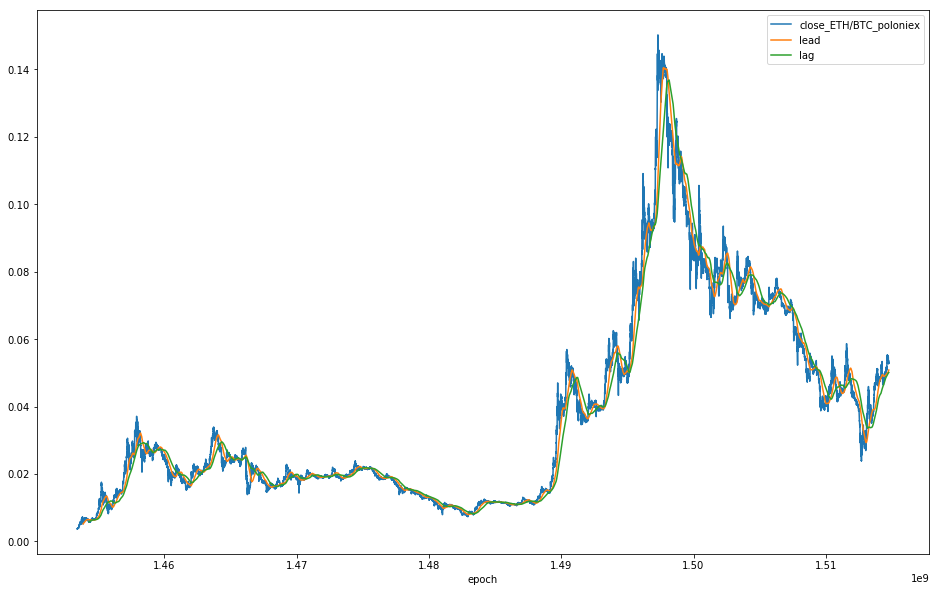

In [237]:
sma_df[[close_col,'lead','lag']].plot(figsize = (16,10))

In [238]:
lead, lag = 1000, 3000
pc_thresh = .025

ma_df = sma_df.copy()
ma_df['lead'] = ma_df[close_col].rolling(lead).mean()
ma_df['lag'] = ma_df[close_col].rolling(lag).mean()
ma_df.dropna(inplace = True)
ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df[close_col]
ma_df['regime'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
ma_df['regime'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['regime'])
ma_df['Market'] = np.log(ma_df[close_col] / ma_df[close_col].shift(1))
ma_df['Strategy'] = ma_df['regime'].shift(1) * ma_df['Market']
ma_df[['Market','Strategy']] = ma_df[['Market','Strategy']].cumsum().apply(np.exp)
ma_df.dropna(inplace=True)

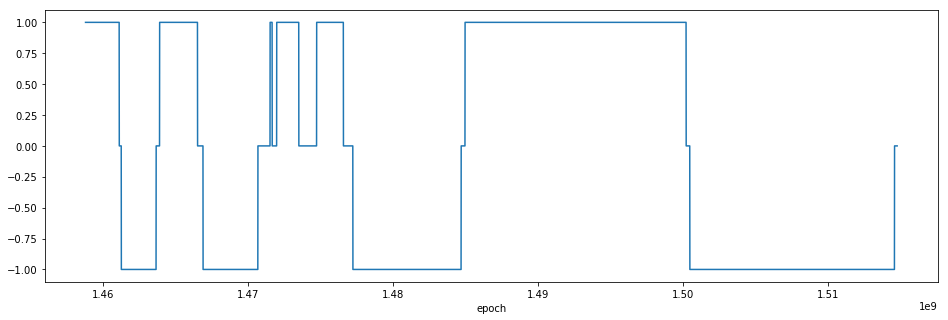

In [239]:
ma_df['regime'].plot(figsize=(16,5))

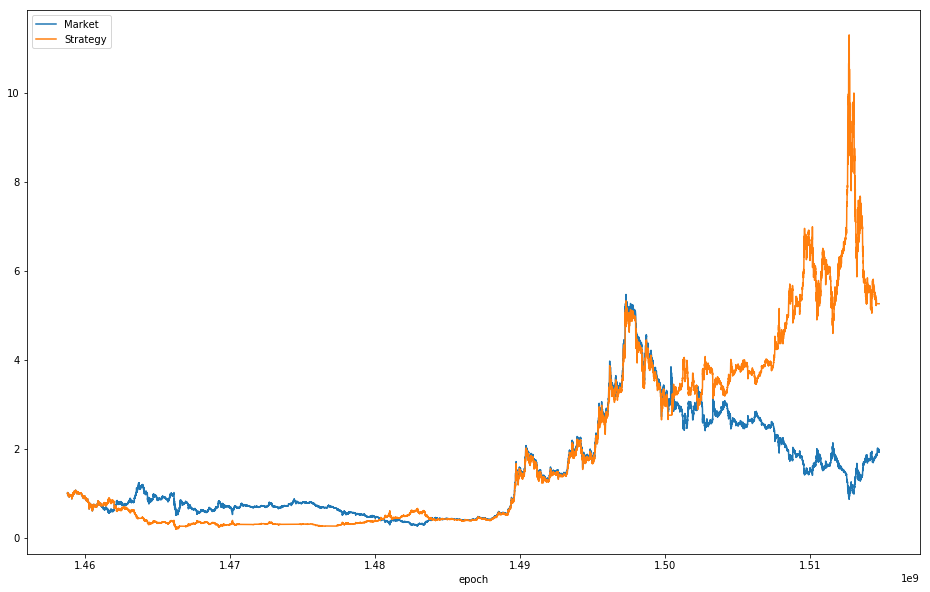

In [240]:
ma_df[['Market','Strategy']].iloc[-1]
ma_df[['Market','Strategy']].plot(figsize = (16,10))

## MACD

* https://romanorac.github.io/cryptocurrency/analysis/2017/12/17/cryptocurrency-analysis-with-python-part1.html

## Linear Regression (OLS)

* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

(34089,)
(28233,) (28233,) (5856,) (5856,)


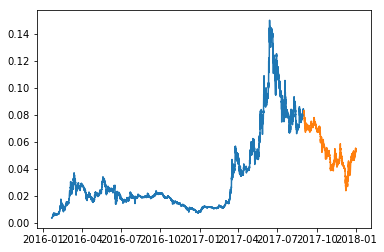

In [241]:
# Numpy Close Data Array
all_utc_arr = np.array(df['utc'])
print(all_utc_arr.shape)

trn_arr = np.array(train[close_col])
trn_utc_arr = np.array(train['utc'])

val_arr = np.array(val[close_col])
val_utc_arr = np.array(val['utc'])
print(trn_arr.shape, trn_utc_arr.shape,val_arr.shape,val_utc_arr.shape)

plt.plot(trn_utc_arr, trn_arr)
plt.plot(val_utc_arr, val_arr)

In [242]:
def get_inp_targs(arr, prior_periods, target_period):
    # Categorical
    # 30 minute timeframe
    # 2 years of data = 35088
    # 48 periods / day
    # Input = 24 periods, output = lower/neutral/higher 
    # (after 12 periods)
    inp = []
    targs = []
    for i in range(0, len(arr[:-target_period])):
        start_close = arr[i]
        end_close = arr[i+target_period]
        pct_delta = (end_close - start_close) / start_close
        inp.append(arr[i:i+prior_periods])
        targs.append(pct_delta)
    inp = np.array(inp)
    targs = np.expand_dims(np.array(targs), axis=1)
    print(inp.shape, targs.shape)
    return inp,targs

In [243]:
trn_inp,trn_targs = get_inp_targs(trn_arr, 12, 24)
val_inp,val_targs = get_inp_targs(val_arr, 12, 24)

(28209, 12) (28209, 1)
(5832, 12) (5832, 1)


In [244]:
linreg = LinearRegression(normalize=True)

linreg.fit(trn_inp, trn_targs)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [245]:
# Intercept and Coefficients
print (linreg.intercept_)
print (linreg.coef_)

[ 0.00507477]
[[-17.40867968  -0.04613288  -0.12012251   0.90920495   0.15054343
    0.45157491  -0.4307423    0.16162315  -0.0461302    0.71426909
    1.03549897  14.57616387]]


In [246]:
# Predict
trn_preds = linreg.predict(trn_inp)
val_preds = linreg.predict(val_inp)
trn_preds.shape, trn_targs.shape, trn_utc_arr.shape

((28209, 1), (28209, 1), (28233,))

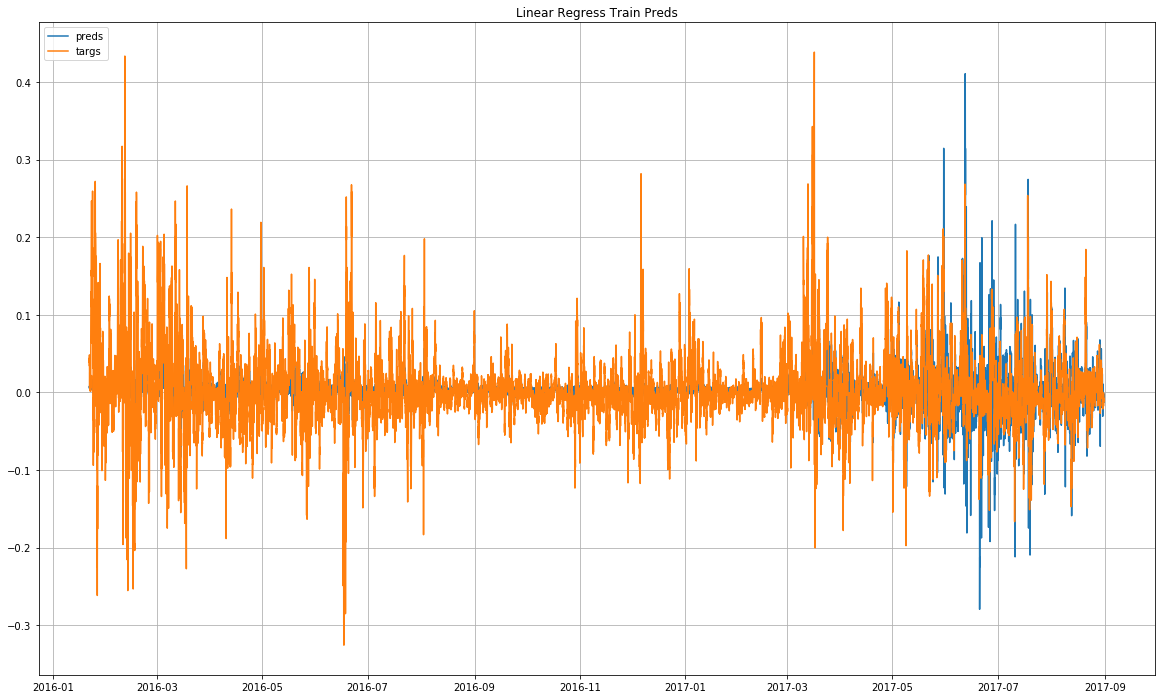

In [247]:
trn_utc_arr = trn_utc_arr[:len(trn_targs)]
plot_AB(trn_preds, trn_targs, x=np.expand_dims(trn_utc_arr,1), 
        title='Linear Regress Train Preds')

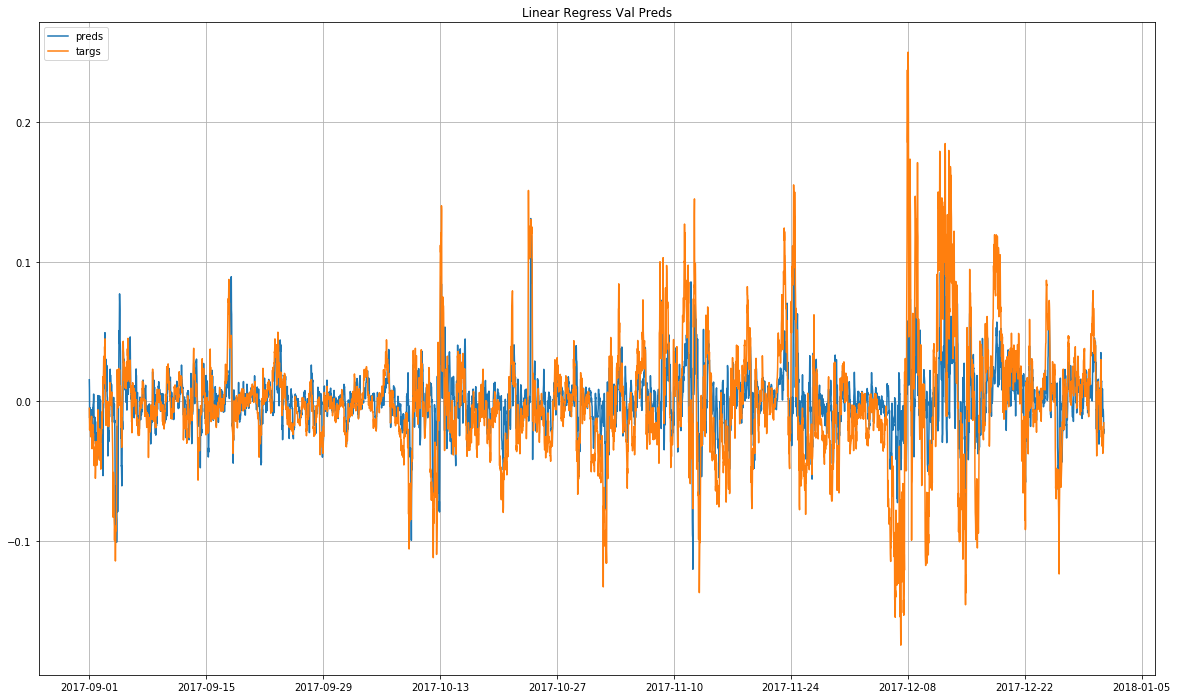

In [248]:
val_utc_arr = val_utc_arr[:len(val_targs)]
plot_AB(val_preds, val_targs, x=np.expand_dims(val_utc_arr,1), title='Linear Regress Val Preds')

In [249]:
# http://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/
print("MAE", metrics.mean_absolute_error(trn_targs, trn_preds))
print("MSE", metrics.mean_squared_error(trn_targs, trn_preds))
print("RMSE", np.sqrt(metrics.mean_squared_error(trn_targs, trn_preds)))

MAE 0.0281079645399
MSE 0.00184721459788
RMSE 0.0429792344962


In [250]:
# http://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/
print("MAE", metrics.mean_absolute_error(val_targs, val_preds))
print("MSE", metrics.mean_squared_error(val_targs, val_preds))
print("RMSE", np.sqrt(metrics.mean_squared_error(val_targs, val_preds)))

MAE 0.0205514547623
MSE 0.000981480819643
RMSE 0.0313285942813


## Logistic Regression (Close)

* https://github.com/bfortuner/ml-study/blob/master/LogisticRegression.ipynb

In [251]:
def get_labels(pct_targs, threshold):
    targs = []
    for targ in pct_targs:
        targ = targ[0]
        if targ < -threshold:
            targs.append(0)
        elif targ > threshold:
            targs.append(2)
        else:
            targs.append(1)
    return np.expand_dims(np.array(targs),1)

def get_one_hot_categorical(targs):
    onehots = preprocessing.OneHotEncoder()
    return onehots.fit(targs).transform(targs).toarray()

# trn_onehots = get_one_hot_categorical(trn_targs, .01)
# val_onehots = get_one_hot_categorical(trn_targs, .01)

(34089,)
(28233,) (28233,) (5856,) (5856,)


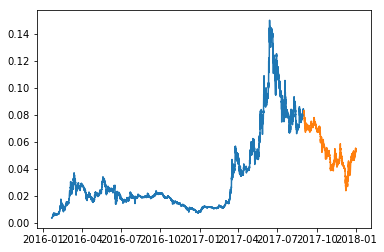

In [252]:
# Numpy Close Data Array
all_utc_arr = np.array(df['utc'])
print(all_utc_arr.shape)

trn_arr = np.array(train[close_col])
trn_utc_arr = np.array(train['utc'])

val_arr = np.array(val[close_col])
val_utc_arr = np.array(val['utc'])
print(trn_arr.shape, trn_utc_arr.shape,val_arr.shape,val_utc_arr.shape)

plt.plot(trn_utc_arr, trn_arr)
plt.plot(val_utc_arr, val_arr)

In [253]:
threshold = .02
trn_inp,trn_targs = get_inp_targs(trn_arr, 12, 24)
val_inp,val_targs = get_inp_targs(val_arr, 12, 24)
trn_labels = get_labels(trn_targs, threshold).ravel()   #Logistic regression expects (n,) shape
val_labels = get_labels(val_targs, threshold).ravel()
normalized_range = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
trn_inp = normalized_range.fit_transform(trn_inp)
val_inp = normalized_range.fit_transform(val_inp)

trn_labels.shape,val_labels.shape

(28209, 12) (28209, 1)
(5832, 12) (5832, 1)


((28209,), (5832,))

In [254]:
model = LogisticRegression()
model.fit(trn_inp, trn_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [255]:
# Predict class labels
trn_preds = model.predict(trn_inp)
val_preds = model.predict(val_inp)
trn_preds,val_preds

(array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 0]))

In [256]:
# Predict probabilities
trn_probs = model.predict_proba(trn_inp)
val_probs = model.predict_proba(val_inp)
trn_probs.shape,val_probs.shape

preds = np.argmax(trn_probs,axis=1)
preds

array([1, 1, 1, ..., 1, 1, 1])

In [257]:
# Accuracy
print("Trn Acc", model.score(trn_inp, trn_labels))
print("Val Acc", model.score(val_inp, val_labels))

Trn Acc 0.542273742423
Val Acc 0.654663923182


In [258]:
# Log Loss
print("Trn Cross Entropy", metrics.log_loss(trn_labels, trn_probs))
print("Val Cross Entropy", metrics.log_loss(val_labels, val_probs))

Trn Cross Entropy 0.943087111732
Val Cross Entropy 0.855124497611


In [259]:
np.unique(trn_preds)

array([0, 1, 2])

(array([   889.,  26165.,   1155.]),
 array([ 0.        ,  0.66666667,  1.33333333,  2.        ]),
 <a list of 3 Patch objects>)

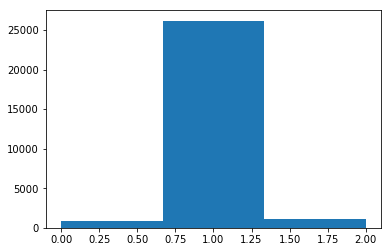

In [260]:
# targets
plt.hist(trn_preds, bins=3, range=(0,2))

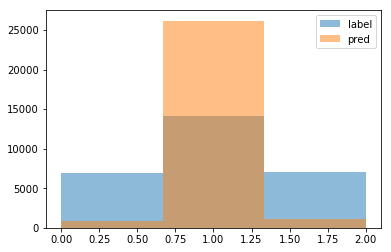

In [261]:
plt.hist(trn_labels, bins=3, alpha=0.5, label='label')
plt.hist(trn_preds, bins=3, alpha=0.5, label='pred')
plt.legend(loc='upper right')
plt.show()

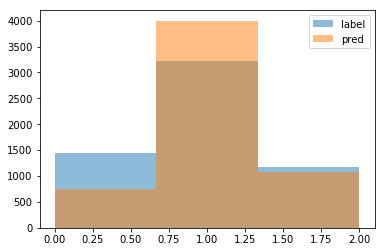

In [262]:
plt.hist(val_labels, bins=3, alpha=0.5, label='label')
plt.hist(val_preds, bins=3, alpha=0.5, label='pred')
plt.legend(loc='upper right')
plt.show()

In [263]:
# Accuracy
print (metrics.accuracy_score(trn_labels, trn_preds))
print (metrics.accuracy_score(val_labels, val_preds))

0.542273742423
0.654663923182


In [264]:
# Classification Report
print (metrics.classification_report(val_labels, val_preds))

             precision    recall  f1-score   support

          0       0.71      0.37      0.48      1437
          1       0.66      0.82      0.73      3212
          2       0.59      0.54      0.57      1183

avg / total       0.66      0.65      0.64      5832



In [265]:
# Confusion Matrix
# https://github.com/bfortuner/ml-study/blob/master/tools/ConfusionMatrix.ipynb 
print (metrics.confusion_matrix(val_labels, val_preds))

[[ 530  848   59]
 [ 186 2644  382]
 [  33  506  644]]


Confusion matrix, without normalization
[[ 530  848   59]
 [ 186 2644  382]
 [  33  506  644]]


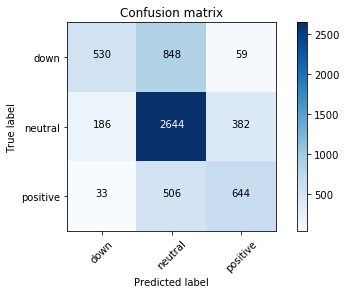

In [266]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(val_labels, val_preds)
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=['down','neutral','positive'],
    title='Confusion matrix')

## Logistic Regression (Close + Volume)

In [267]:
def get_inp_targs(arr, prior_periods, target_period):
    # Categorical
    # 30 minute timeframe
    # 2 years of data = 35088
    # 48 periods / day
    # Input = 24 periods, output = lower/neutral/higher 
    # (after 12 periods)
    inp = []
    targs = []
    for i in range(0, len(arr[:-target_period,:])):
        start_close = arr[i][0]
        end_close = arr[i+target_period][0]
        pct_delta = (end_close - start_close) / start_close
        inp.append(arr[i:i+prior_periods])
        targs.append(pct_delta)
    inp = np.array(inp)
    n_samples, timesteps, cols = inp.shape
    inp = inp.reshape((n_samples, timesteps * cols))
    targs = np.expand_dims(np.array(targs), axis=1)
    print(inp.shape, targs.shape)
    return inp,targs

In [268]:
split_date =  datetime.datetime(year=2017, month=9, day=1)
train = df[df['utc'] < split_date]
val = df[df['utc'] >= split_date]

(34089,)
(28233, 3) (28233,) (5856, 3) (5856,)


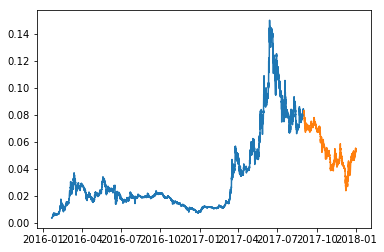

In [269]:
# Numpy Close Data Array
all_utc_arr = np.array(df['utc'])
print(all_utc_arr.shape)

trn_arr = np.array(train[[close_col, volume_col, 'lag']])
trn_utc_arr = np.array(train['utc'])

val_arr = np.array(val[[close_col, volume_col, 'lag']])
val_utc_arr = np.array(val['utc'])
print(trn_arr.shape, trn_utc_arr.shape,val_arr.shape,val_utc_arr.shape)

# Price
plt.plot(trn_utc_arr, trn_arr[:,0])
plt.plot(val_utc_arr, val_arr[:,0])

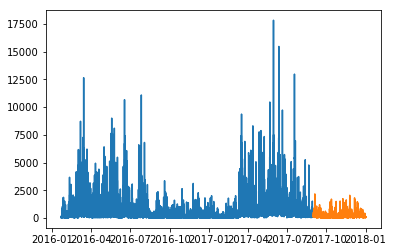

In [270]:
# Volume
plt.plot(trn_utc_arr, trn_arr[:,1])
plt.plot(val_utc_arr, val_arr[:,1])

In [271]:
threshold = .02
trn_inp,trn_targs = get_inp_targs(trn_arr, 12, 24)
val_inp,val_targs = get_inp_targs(val_arr, 12, 24)
trn_labels = get_labels(trn_targs, threshold).ravel()   #Logistic regression expects (n,) shape
val_labels = get_labels(val_targs, threshold).ravel()
normalized_range = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
trn_inp = normalized_range.fit_transform(trn_inp)
val_inp = normalized_range.fit_transform(val_inp)

(28209, 36) (28209, 1)
(5832, 36) (5832, 1)


In [272]:
model = LogisticRegression()
model.fit(trn_inp, trn_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [273]:
# Predict class labels
trn_preds = model.predict(trn_inp)
val_preds = model.predict(val_inp)

In [274]:
# Predict probabilities
trn_probs = model.predict_proba(trn_inp)
val_probs = model.predict_proba(val_inp)
trn_probs.shape,val_probs.shape

trn_preds,trn_probs,val_preds,val_probs

(array([1, 1, 1, ..., 1, 1, 1]),
 array([[ 0.19323629,  0.57978054,  0.22698316],
        [ 0.19210931,  0.58291582,  0.22497488],
        [ 0.19021636,  0.58455837,  0.22522527],
        ..., 
        [ 0.23213612,  0.66923413,  0.09862975],
        [ 0.2325798 ,  0.66812387,  0.09929633],
        [ 0.21699717,  0.67827332,  0.10472952]]),
 array([2, 1, 1, ..., 1, 1, 1]),
 array([[ 0.11965535,  0.39633797,  0.48400668],
        [ 0.18601158,  0.49773689,  0.31625153],
        [ 0.35707814,  0.43582325,  0.20709861],
        ..., 
        [ 0.25113599,  0.61387826,  0.13498575],
        [ 0.38393352,  0.53712935,  0.07893713],
        [ 0.42195733,  0.52907693,  0.04896574]]))

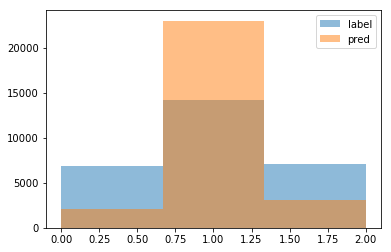

In [275]:
plt.hist(trn_labels, bins=3, alpha=0.5, label='label')
plt.hist(trn_preds, bins=3, alpha=0.5, label='pred')
plt.legend(loc='upper right')
plt.show()

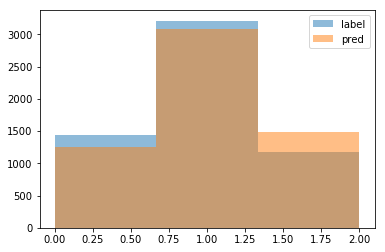

In [276]:
plt.hist(val_labels, bins=3, alpha=0.5, label='label')
plt.hist(val_preds, bins=3, alpha=0.5, label='pred')
plt.legend(loc='upper right')
plt.show()

In [277]:
# Accuracy
print ("Trn Acc", metrics.accuracy_score(trn_labels, trn_preds))
print ("Val Acc", metrics.accuracy_score(val_labels, val_preds))

Trn Acc 0.597043496756
Val Acc 0.633744855967


Confusion matrix, without normalization
[[ 1421  5209   298]
 [  446 13170   563]
 [  184  4667  2251]]


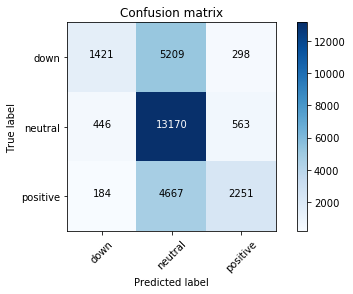

In [278]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(trn_labels, trn_preds)
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=['down','neutral','positive'],
    title='Confusion matrix')

Confusion matrix, without normalization
[[ 729  565  143]
 [ 441 2199  572]
 [  88  327  768]]


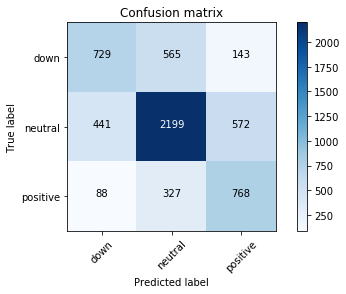

In [279]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(val_labels, val_preds)
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=['down','neutral','positive'],
    title='Confusion matrix')

## Logistic Regression (Method)

In [280]:
def get_inp_targs(arr, prior_periods, target_period):
    # Categorical
    # 30 minute timeframe
    # 2 years of data = 35088
    # 48 periods / day
    # Input = 24 periods, output = lower/neutral/higher 
    # (after 12 periods)
    inp = []
    targs = []
    for i in range(0, len(arr[:-target_period,:])):
        start_close = arr[i][0]
        end_close = arr[i+target_period][0]
        pct_delta = (end_close - start_close) / start_close
        inp.append(arr[i:i+prior_periods])
        targs.append(pct_delta)
    inp = np.array(inp)
    n_samples, timesteps, cols = inp.shape
    inp = inp.reshape((n_samples, timesteps * cols))
    targs = np.expand_dims(np.array(targs), axis=1)
    return inp,targs

def get_log_reg_inputs(df, columns, prior_periods, target_period):
    arr = np.array(df[columns])
    threshold = .02
    inp,targs = get_inp_targs(arr, prior_periods, target_period)
    labels = get_labels(targs, threshold).ravel()
    normalized_range = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
    inp = normalized_range.fit_transform(inp)
    return inp,targs,labels

def train_model(trn_inp, trn_labels):
    model = LogisticRegression()
    model.fit(trn_inp, trn_labels)
    return model

def predict(model, inp):
    # Predict class labels
    preds = model.predict(inp)
    probs = model.predict_proba(inp)
    return preds,probs

def evaluate(preds, probs, labels, plot_charts=True):
    if plot_charts:
        cnf_matrix = metrics.confusion_matrix(labels, preds)
        plt.figure()
        plot_confusion_matrix(
            cnf_matrix, classes=['down','neutral','positive'],
            title='Confusion matrix')
        plt.show()
        plt.hist(labels, bins=3, alpha=0.5, label='label')
        plt.hist(preds, bins=3, alpha=0.5, label='pred')
        plt.legend(loc='upper right')
        plt.show()
    acc = metrics.accuracy_score(labels, preds)
    logloss = metrics.log_loss(labels, probs)
    return acc, logloss

In [281]:
def run_experiment(columns, prior_periods, target_period):
    trn_inp,trn_targs,trn_labels = get_log_reg_inputs(
        train, columns, prior_periods, target_period)
    val_inp,val_targs,val_labels = get_log_reg_inputs(
        val, columns, prior_periods, target_period)

    model = train_model(trn_inp, trn_labels)

    trn_preds,trn_probs = predict(model, trn_inp)
    val_preds,val_probs = predict(model, val_inp)

    acc, loss = evaluate(trn_preds, trn_probs, trn_labels, False)
    print("Trn - Acc: {:.4f} Loss: {:.4f}".format(float(acc), float(loss)))
    acc, loss = evaluate(val_preds, val_probs, val_labels, False)
    print("val - Acc: {:.4f} Loss: {:.4f}".format(float(acc), float(loss)))
        

In [282]:
# Prep inputs
# https://coinmarketcap.com/api/
exchange_id = ex_cfg.POLONIEX
asset = Asset(coins.ETH, coins.BTC)
start = datetime.datetime(year=2016, month=1, day=1)
end = datetime.datetime(year=2018, month=1, day=1)
timeframe = Timeframe.THIRTY_MIN
exchange = load_exchange(exchange_id)
#ohlcv_feed.fetch_and_save_asset(exchange, asset, timeframe, start, end)
#feed = OHLCVFileFeed([exchange_id], [asset], timeframe, start, end)
fpath = ohlcv_feed.get_ohlcv_fpath(asset, exchange_id, timeframe)
df = ohlcv_feed.load_asset(fpath)
df.sort_values(by='utc', inplace=True)
close_col = ohlcv_feed.get_col_name('close', asset.symbol, exchange_id)
volume_col = ohlcv_feed.get_col_name('volume', asset.symbol, exchange_id)
df['lead'] = df[close_col].rolling(1000).mean()
df['lag'] = df[close_col].rolling(5000).mean()
df.dropna(inplace=True)
df.head()

split_date =  datetime.datetime(year=2017, month=9, day=1)
train = df[df['utc'] < split_date]
val = df[df['utc'] >= split_date]
trn_inp,trn_targs,trn_labels = get_log_reg_inputs(
    train, columns, prior_periods, target_period)
val_inp,val_targs,val_labels = get_log_reg_inputs(
    val, columns, prior_periods, target_period)
val_inp.shape,val_targs.shape

((5832, 24), (5832, 1))

In [283]:
prior_periods = 12
target_period = 24
columns = [close_col, volume_col, 'lead', 'lag']
run_experiment(columns, prior_periods, target_period)

Trn - Acc: 0.6162 Loss: 0.8687
val - Acc: 0.6274 Loss: 0.9530


In [ ]:
# close seems best

# 8 prior, 1 - 4 predict
columns = [close_col]#, volume_col, 'lead', 'lag']
for i in range(1,len(columns)+1):
    cols = columns[:i]
    for pp in [4,8,12,16,20,24]:
        for tp in [pp+1, pp+2, pp+4, pp+6, pp+10, pp+12]:
            print(pp, tp, cols)
            run_experiment(cols, pp, tp)

In [ ]:
"""
Best Results (all 'close')

prior_periods = 4
target_period = 5 (next timestep)
Trn - Acc: 0.8065 Loss: 0.5897
val - Acc: 0.8188 Loss: 0.5779

4 6
Trn - Acc: 0.7819 Loss: 0.6430
val - Acc: 0.7938 Loss: 0.6383

4 8 
Trn - Acc: 0.7344 Loss: 0.7347
val - Acc: 0.7527 Loss: 0.7286

-------

8 9 
Trn - Acc: 0.7240 Loss: 0.6964
val - Acc: 0.7754 Loss: 0.6046

8 10
Trn - Acc: 0.7054 Loss: 0.7337
val - Acc: 0.7552 Loss: 0.6635

8 12 
Trn - Acc: 0.6745 Loss: 0.7906
val - Acc: 0.7310 Loss: 0.7294

-----

12 13
Trn - Acc: 0.6853 Loss: 0.7308
val - Acc: 0.7835 Loss: 0.6291

12 14
Trn - Acc: 0.6716 Loss: 0.7557
val - Acc: 0.7646 Loss: 0.6627

12 16
Trn - Acc: 0.6466 Loss: 0.8015
val - Acc: 0.7300 Loss: 0.7286


Questions:
1) When it's wrong, what are the financial consequences?
2) When it's right, how much do we make?
"""

## SVM

* https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
* https://www.quantstart.com/articles/Forecasting-Financial-Time-Series-Part-1
* http://scikit-learn.org/stable/modules/svm.html

Val (5832, 48) (5832, 1) (5832,)


<Container object of 3 artists>

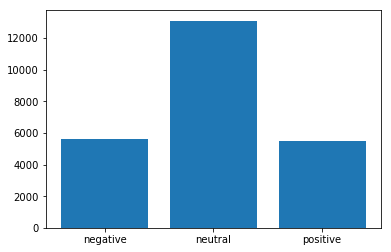

In [284]:
# Prep inputs
# https://coinmarketcap.com/api/
exchange_id = ex_cfg.POLONIEX
asset = Asset(coins.ETH, coins.BTC)
start = datetime.datetime(year=2016, month=1, day=1)
end = datetime.datetime(year=2018, month=1, day=1)
timeframe = Timeframe.THIRTY_MIN
exchange = load_exchange(exchange_id)
#ohlcv_feed.fetch_and_save_asset(exchange, asset, timeframe, start, end)
#feed = OHLCVFileFeed([exchange_id], [asset], timeframe, start, end)
fpath = ohlcv_feed.get_ohlcv_fpath(asset, exchange_id, timeframe)
df = ohlcv_feed.load_asset(fpath)
df.sort_values(by='utc', inplace=True)
close_col = ohlcv_feed.get_col_name('close', asset.symbol, exchange_id)
volume_col = ohlcv_feed.get_col_name('volume', asset.symbol, exchange_id)
df['lead'] = df[close_col].rolling(1000).mean()
df['lag'] = df[close_col].rolling(5000).mean()
df.dropna(inplace=True)
df.head()

split_date =  datetime.datetime(year=2017, month=9, day=1)
train = df[df['utc'] < split_date]
val = df[df['utc'] >= split_date]
trn_inp,trn_targs,trn_labels = get_log_reg_inputs(
    train, columns, prior_periods, target_period)
val_inp,val_targs,val_labels = get_log_reg_inputs(
    val, columns, prior_periods, target_period)
print("Val", val_inp.shape,val_targs.shape,val_labels.shape)
unique_counts = np.unique(trn_labels, return_counts=True)
unique_counts[0]
plt.bar(left=unique_counts[0], height=unique_counts[1], tick_label=['negative','neutral', 'positive'])

In [285]:
def run_svm_experiment(columns, prior_periods, target_period):
    trn_inp,trn_targs,trn_labels = get_log_reg_inputs(
        train, columns, prior_periods, target_period)
    val_inp,val_targs,val_labels = get_log_reg_inputs(
        val, columns, prior_periods, target_period)

    model = svm.SVC(probability=True)
    model.fit(trn_inp, trn_labels)
    
    trn_preds,trn_probs = predict(model, trn_inp)
    val_preds,val_probs = predict(model, val_inp)

    acc, loss = evaluate(trn_preds, trn_probs, trn_labels, False)
    print("Trn - Acc: {:.4f} Loss: {:.4f}".format(float(acc), float(loss)))
    acc, loss = evaluate(val_preds, val_probs, val_labels, False)
    print("val - Acc: {:.4f} Loss: {:.4f}".format(float(acc), float(loss)))

In [228]:
columns = [close_col]
run_svm_experiment(columns, prior_periods, target_period)

Trn - Acc: 0.5415 Loss: 0.8957
val - Acc: 0.5580 Loss: 1.0062


In [229]:
columns = [close_col, volume_col]
run_svm_experiment(columns, prior_periods, target_period)

Trn - Acc: 0.5845 Loss: 0.9052
val - Acc: 0.6145 Loss: 1.0145


In [ ]:
# 8 prior, 1 - 4 predict
columns = [close_col, volume_col, 'lead', 'lag']
for i in range(1,len(columns)+1):
    cols = columns[:i]
    for pp in [4,8,12,16,20,24]:
        for tp in [pp+1, pp+2, pp+4, pp+6, pp+10, pp+12]:
            print(pp, tp, cols)
            run_experiment(cols, pp, tp)

## Random Forest

## ARIMA

* https://dashee87.github.io/data%20science/general/A-Road-Incident-Model-Analysis/

## Facebook Prophet

* https://github.com/facebook/prophet